# Exploration of Boundary Conditions of N-Coupled Oscillators

## Introduction 

For our system, we will have N masses coupled to one another by a spring with stiffness $k_s$ to create a chain of N-oscillators. We will explore the time evolution of a N-coupled oscillators for three different situations:

- A chain that is fixed on both ends
- A chain that is fixed on one end and free on the other
- A chain that is free on both ends


## Theory

The general solution for mass $i$ can be written as a linear combination of the $N$ normal modes:

$$u_i(t) = \sum_{n=1}^{N} C_{i,n}a_{i,n}\cos(\omega_n t + \phi_{n})$$

Where $C_{i,n}$ and  $\phi_{n}$ depend on the initial conditions of the masses. 

To solve for the displacement $u_i(t)$ for each mass, we must first find $a_{i,n}$ and $\omega_n$, which are the amplitudes and frequencies that are specific to each mass. To simplifiy calculations, we can create a vector of the particular amplitudes for each mass called an eigenvectors $\vec{a}_n$ for a given normal mode.

The eigenvectors are written as, where i = 1, 2, 3, ...

$$ \vec{a}_n=
\left[ {\begin{array}{c}
    a_{1,n} \\
    a_{2,n} \\
    a_{3,n} \\
    . \\
    . \\
    . \\
  \end{array} } \right]
$$





## Simulation

The program below implements an algorithm using linear algebra to calculate the time evolution of a chain of N-oscillators using the general solution above for given initial conditions and three different boundary conditions. It will:

1. find the frequencies of the normal modes.
2. find the eigenvectors of the normal modes.
3. find the coefficients based on initial positions of the masses (assuming zero initial velocity).
4. calculate the displacement of each mass for all times (using general solution)

Once the function is called, it will display an animation of the chain of N-oscillators for a given boundary condition. Using the previously calculated eigenvectors and eigenvalues, we can visualize the normal modes for each mass.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#animate with vpython
from vpython import * #watch out for namespace conflicts

# calculate eigenvalues and eigenvectors
from scipy.linalg import eigh

# print to markdown
from IPython.display import display, Markdown, Latex


<IPython.core.display.Javascript object>

The function 'oscill(N,boundary)' calculates the time evolution for a given chain of N masses and boundary condition. The first input 'N' is the number of masses and requires an integer greater than 5. The second input 'boundary' is a variable that holds string of either "freefree", "fixedfree", or "fixedfixed", to determine the boundary condition. This function returns the number of masses 'N', the eigenvectors 'a', the frequencies 'omegas', and the set boundary condition 'boundary'.

In [2]:
def oscill(N,boundary):
    
    if(boundary!= "freefree" and boundary!="fixedfree" and boundary!="fixedfixed"):
        print("Enter a correct boundary condition as a string")
        return
    
    #properties of the system
    M = 12 #mass of string in kg
    L = 10 #length of string in m
    K = 1 #effective stiffness in N/m

    #properties of each mass
    m = M/N
    L0 = L/(N-1)
    k = K*(N-1)


    #Build matrices
    A=np.zeros((N,N))

    for i in range(N):
        A[i,i] = 2*k
        if i==0:
            A[0,i+1]=-k
            if(boundary=="freefree"):
                A[i,i] = k #free end
        elif i==N-1:
            A[i,i-1]=-k
            if(boundary=="freefree" or boundary == "fixedfree"):
                A[i,i] = k #free end
        else:
            A[i,i-1]=-k
            A[i,i+1]=-k

    B=m*np.identity(N)

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B)        # eigenvalues and eigenvectors
    omegas = np.sqrt(lamb)


    ui = np.zeros(N) #initial displacement
    ui[0] = -L0/2 #displace first mass

    #calculate coefficients using initial conditions
    C = np.linalg.solve(a,ui)


    #build the general solution
    h = 0.01
    ttotal = 20
    t = np.arange(0,ttotal,h)

    u = np.zeros((len(t),N+1))
    u[:,0] = np.transpose(t) #store time in first column, u_i in other columns

    for i in range(N):
        for w in range(0,len(omegas)):
            u[:,i+1] = u[:,i+1] + C[w]*a[i,w]*np.cos(omegas[w]*t)


    ################_Animation_####################
    scene=canvas()

    scene.background=color.white
    scene.fov = 0.1

    thick = L0/20
    height=L0/2
    
    if(boundary=="fixedfixed" or boundary == "fixedfree"):
        wall1 = box(pos= vec(-L/2 - thick, 0, 0), size=vec(thick,height,height), color=vec(0.5,0.5,0.5))
    if(boundary=="fixedfixed"):
        wall2 = box(pos=wall1.pos + vec(L+2*thick,0,0), size=wall1.size, color=wall1.color)


    balls=[]
    if(boundary=="fixedfixed"):
        xballs = np.linspace(-L/2+L0,L/2-L0,N)
    if(boundary=="fixedfree"):
        xballs = np.linspace(-L/2+L0,L/2,N)
    if(boundary=="freefree"):
        xballs = np.linspace(-L/2,L/2,N)

    springs=[]
    if(boundary=="fixedfixed" or boundary == "fixedfree"):
        springs.append(helix(pos=vec(-L/2,0,0), axis=vec(L0,0,0), color=color.orange, radius=L0/20))

    i=0
    for x in xballs:
        ball = sphere(pos=vec(x,0,0), radius=L0/10, color=color.red)
        ball.eq = x
        balls.append(ball)
        if(boundary=="fixedfree" or boundary == "freefree"):
            if i < N-1: #no spring to the right of the last mass
                spring = helix(pos=ball.pos, axis=vec(L0,0,0), color=color.orange, radius=ball.radius/2)
                springs.append(spring)
            i = i + 1
        elif(boundary=="fixedfixed"):
                spring = helix(pos=ball.pos, axis=vec(L0,0,0), color=color.orange, radius=ball.radius/2)
                springs.append(spring)
            

    #set initial positions
    for i in range(0,len(balls)):
        ball = balls[i]
        ball.pos.x = ball.eq + u[0,i+1]
    if(boundary=="fixedfree"):    
        for i in range(1, len(springs)): #all springs except first 
            spring = springs[i]
            spring.pos=balls[i-1].pos
            spring.axis=balls[i].pos-spring.pos

        #update first spring
        springs[0].axis = balls[0].pos-springs[0].pos
    if(boundary == "fixedfixed"):
        for i in range(1, len(springs)-1): #all springs except first 
            spring = springs[i]
            spring.pos=balls[i-1].pos
            spring.axis=balls[i].pos-spring.pos
            
        #update first spring and last spring
        springs[0].axis = balls[0].pos-springs[0].pos
        springs[-1].pos = balls[-1].pos
        springs[-1].axis = vec(L/2,0,0)-springs[-1].pos
    if(boundary=="freefree"):
        for i in range(0, len(springs)):
            spring = springs[i]
            spring.pos=balls[i].pos
            spring.axis=balls[i+1].pos-spring.pos
        
   
    #animate
    scene.pause()
    t=0
    for n in range(len(u[:,0])):
        rate(200)
        for i in range(0,len(balls)):
            ball = balls[i]
            ball.pos.x = ball.eq + u[n,i+1]
        if(boundary=="fixedfree"):    
            for i in range(1, len(springs)): #all springs except first 
                spring = springs[i]
                spring.pos=balls[i-1].pos
                spring.axis=balls[i].pos-spring.pos

            #update first spring
            springs[0].axis = balls[0].pos-springs[0].pos
        if(boundary == "fixedfixed"):
            for i in range(1, len(springs)-1): #all springs except first 
                spring = springs[i]
                spring.pos=balls[i-1].pos
                spring.axis=balls[i].pos-spring.pos

            #update first spring and last spring
            springs[0].axis = balls[0].pos-springs[0].pos
            springs[-1].pos = balls[-1].pos
            springs[-1].axis = vec(L/2,0,0)-springs[-1].pos
        if(boundary=="freefree"):
            for i in range(0, len(springs)):
                spring = springs[i]
                spring.pos=balls[i].pos
                spring.axis=balls[i+1].pos-spring.pos
              

        
    return N, a, omegas, boundary

The 'normal()' function produces a plot of the normal modes for a given set of eigenvalues and eigenvectors. This functions accepts four different arguments. The first argument, 'mode', is the desired mode a user may want to visualize. The second argument 'a' are the eigenvectors that should have been returned by the oscill() function. The third argument 'omegas', are the calculated frequencies returned by the oscill() function. The last argument 'cnd', is the previously chosen boundary condition used in the oscill() function.

In [3]:
def normal(mode, N, a, omegas, cnd):
    
    mode = mode-1
    h = 0.01
    ttotal = 20 #total time for calculations

    # array of times
    t = np.arange(0,ttotal,h)

    # build data array with all data; u[:,0] is time; other columns are u_i for each atom i
    u = np.zeros((int(ttotal/h), N+1))

    u[:,0] = np.transpose(t) #t.T

    for i in range(N):
        u_atom = a[i,mode]*np.cos(omegas[mode]*t)
        u[:,i+1] = np.transpose(u_atom)[:]

    # plot
    plt.figure(figsize=(12,8))
    if(cnd == "fixedfixed"):
        plt.title("Normal Mode of Each Mass for FixedFixed Condition")
    elif(cnd == "fixedfree"):
        plt.title("Normal Mode of Each Mass for FixedFree Condition")
    elif(cnd == "freefree"):
        plt.title("Normal Mode of Each Mass for FreeFree Condition")
    
    plt.xlabel("t (s)")
    plt.ylabel("$u_i$ (m)")
    for i in range(N): #plot each atom
        plt.plot(u[:,0], u[:,i+1], label="mass {:d}".format(i+1))
    plt.grid()
    plt.legend()
    plt.show()
    return

Below are examples of the function being used for N=15 masses for all three boundary conditions.

In [82]:
masses1, ev1, freq1, cnd1 = oscill(15,"fixedfixed")

<IPython.core.display.Javascript object>

In [5]:
masses2, ev2, freq2, cnd2= oscill(10,"fixedfree")

<IPython.core.display.Javascript object>

In [84]:
masses3, ev3, freq3, cnd3 = oscill(15,"freefree")

<IPython.core.display.Javascript object>

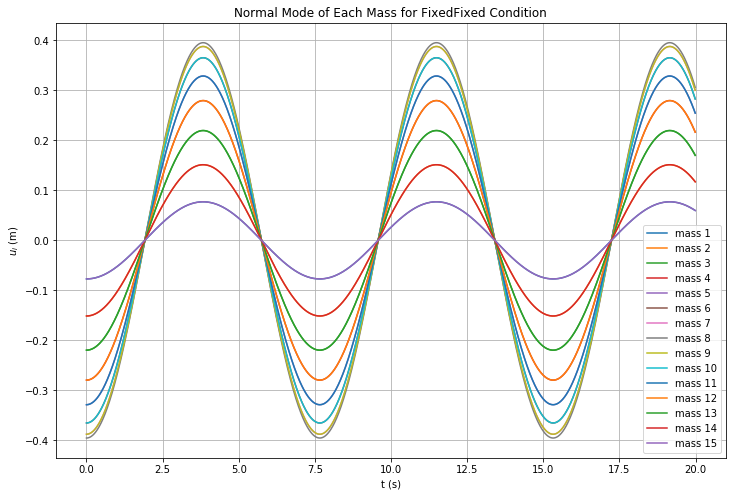

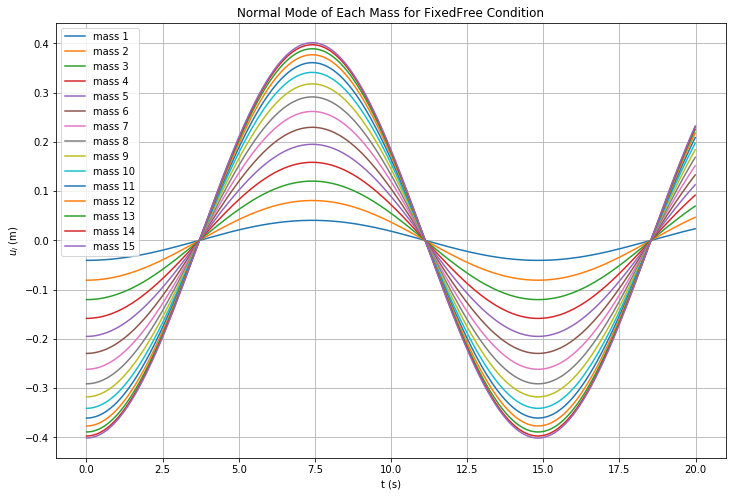

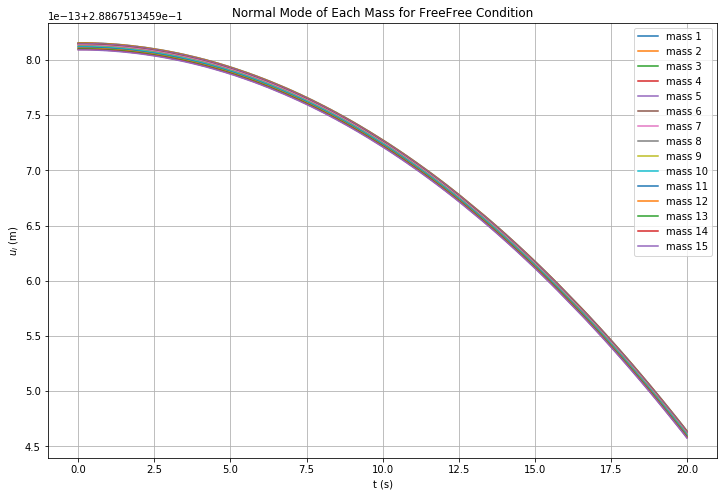

In [85]:
normal(1,masses1, ev1, freq1, cnd1)
normal(1,masses2, ev2, freq2, cnd2)
normal(1,masses3, ev3, freq3, cnd3)

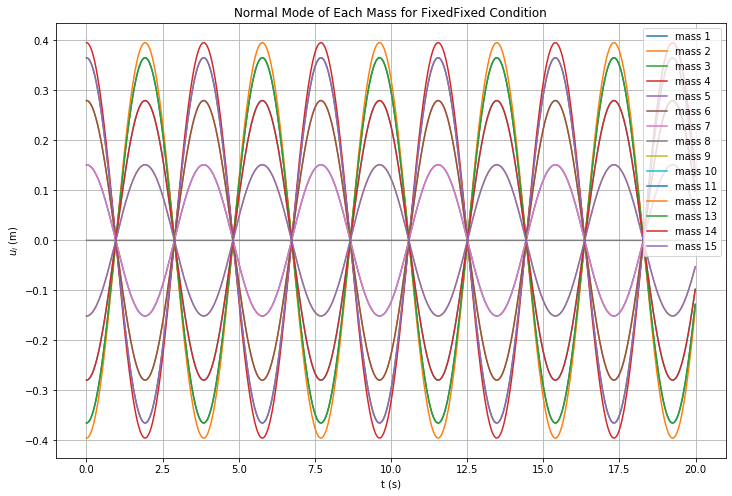

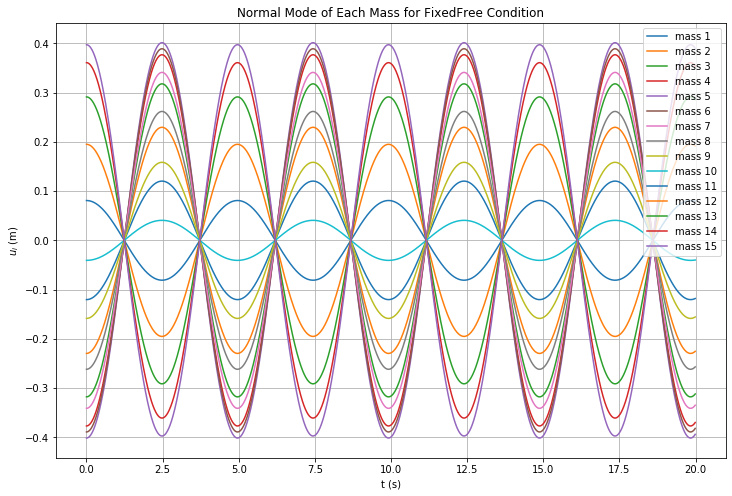

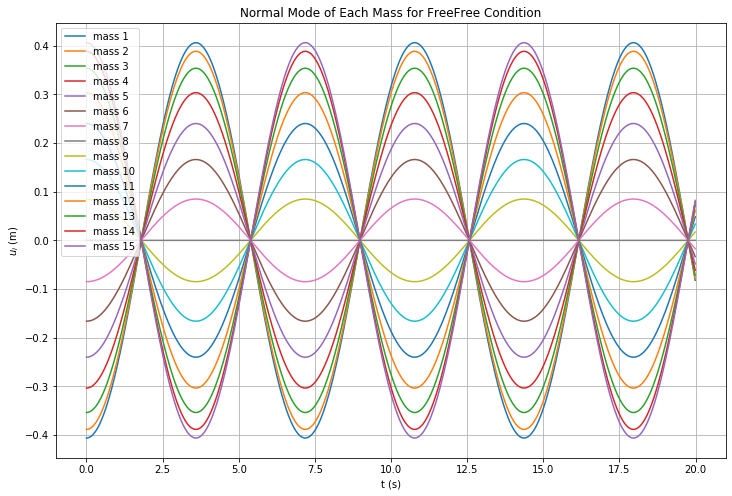

In [86]:
normal(5,masses1, ev1, freq1, cnd1)
normal(5,masses2, ev2, freq2, cnd2)
normal(5,masses3, ev3, freq3, cnd3)

## Conclusion

After simulating a chain of N=15 coupled oscillators, we can see the behavior of each system over a period of time. When comapring the animations, the longitudinal wave created for each boundary conditions differs as expected. When comparing the normal nodes for each boundary condition, it seems that the "fixedfree" case looks much different than the other two cases. Obviously the "fixedfixed" and "freefree" normal modes are not exactly the same, they seem to show similar behaviors. This is possibly due to the symmetry shared by these two systems. In the end, this program achieves the simulation of N-coupled oscillators for three different boundary conditions. This program is robust enough to explore different number of masses, mass values, initial conditions, and spring stiffnesses.

